In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
data = pd.read_csv('train.csv')

In [183]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Imputación de nulos

In [185]:
# Revisión de valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())
print("\nPorcentaje de valores nulos por columna:")
print(data.isnull().sum()/len(data) * 100)

# Revisión de duplicados
duplicados = data.duplicated().sum()
print(f"\nNúmero de registros duplicados: {duplicados}")

# Revisión de tipos de datos
print("\nTipos de datos de las columnas:")
print(data.dtypes)

Valores nulos por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Porcentaje de valores nulos por columna:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Número de registros duplicados: 0

Tipos de datos de las columnas:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [186]:
# Poner la columna 'Age' mediante KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data['Age'] = imputer.fit_transform(data[['Age', 'Pclass', 'Fare']])[:, 0]

# Poner la columna 'Embarked' con la moda
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Poner la columna 'Cabin' con "Unknown" 
data['Cabin'] = data['Cabin'].fillna("Unknown")

# Feature Engineering

In [187]:
import re

def extraer_titulo_robusto(nombre):
    """
    Función robusta para extraer títulos/gentilicios de nombres completos.
    
    Parámetros:
    nombre (str): Nombre completo de la persona
    
    Retorna:
    str: Título extraído y normalizado
    """
    if pd.isna(nombre) or not isinstance(nombre, str):
        return 'Unknown'
    
    # Diccionario de mapeo para normalizar títulos
    titulo_mapping = {
        # Títulos masculinos
        'Mr': 'Mr',
        'Master': 'Master',
        'Rev': 'Rev',
        'Dr': 'Dr',
        'Major': 'Military',
        'Col': 'Military',
        'Capt': 'Military',
        'Sir': 'Nobility',
        'Don': 'Nobility',
        'Jonkheer': 'Nobility',
        
        # Títulos femeninos
        'Mrs': 'Mrs',
        'Miss': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs',
        'Mlle': 'Miss',
        'Lady': 'Nobility',
        'Countess': 'Nobility',
        'Dona': 'Nobility',
        
        # Títulos profesionales
        'Prof': 'Dr',
        'Doctor': 'Dr',
        'Professor': 'Dr'
    }
    
    # Patrón regex para encontrar títulos
    # Busca palabras que terminan en punto o están seguidas de un espacio/punto
    patron = r'\b([A-Za-z]+\.?)\s'
    
    # Buscar todos los posibles títulos
    matches = re.findall(patron, nombre)
    
    for match in matches:
        # Limpiar el match (quitar puntos)
        titulo_limpio = match.replace('.', '')
        
        # Verificar si es un título conocido
        if titulo_limpio in titulo_mapping:
            return titulo_mapping[titulo_limpio]
        
        # Verificar variaciones comunes
        titulo_lower = titulo_limpio.lower()
        for key in titulo_mapping.keys():
            if titulo_lower == key.lower():
                return titulo_mapping[key]
    
    # Si no se encuentra un título específico, intentar con patrones más generales
    # Buscar palabras entre comas (formato: Apellido, Título. Nombre)
    if ',' in nombre:
        partes = nombre.split(',')
        if len(partes) >= 2:
            segunda_parte = partes[1].strip()
            # Buscar título en la segunda parte
            titulo_match = re.search(r'\b([A-Za-z]+)', segunda_parte)
            if titulo_match:
                titulo_encontrado = titulo_match.group(1)
                if titulo_encontrado in titulo_mapping:
                    return titulo_mapping[titulo_encontrado]
    
    # Como último recurso, categorizar por patrones de género
    nombre_lower = nombre.lower()
    if any(fem in nombre_lower for fem in ['miss', 'mrs', 'ms', 'lady', 'mme', 'mlle']):
        return 'Miss' if 'miss' in nombre_lower or 'mlle' in nombre_lower else 'Mrs'
    elif any(masc in nombre_lower for masc in ['mr', 'master', 'sir', 'don']):
        return 'Master' if 'master' in nombre_lower else 'Mr'
    
    return 'Unknown'

# Aplicar la función al dataset
data['Titulo'] = data['Name'].apply(extraer_titulo_robusto)

# Mostrar la distribución de títulos extraídos
print("Distribución de Títulos Extraídos:")
print("="*40)
print(data['Titulo'].value_counts())

# Mostrar algunos ejemplos
print("\nEjemplos de extracción:")
print("="*40)
ejemplos = data[['Name', 'Titulo']].head(10)
for idx, row in ejemplos.iterrows():
    print(f"Nombre: {row['Name']}")
    print(f"Título: {row['Titulo']}")
    print("-" * 50)

Distribución de Títulos Extraídos:
Titulo
Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Nobility      5
Military      5
Name: count, dtype: int64

Ejemplos de extracción:
Nombre: Braund, Mr. Owen Harris
Título: Mr
--------------------------------------------------
Nombre: Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Título: Mrs
--------------------------------------------------
Nombre: Heikkinen, Miss. Laina
Título: Miss
--------------------------------------------------
Nombre: Futrelle, Mrs. Jacques Heath (Lily May Peel)
Título: Mrs
--------------------------------------------------
Nombre: Allen, Mr. William Henry
Título: Mr
--------------------------------------------------
Nombre: Moran, Mr. James
Título: Mr
--------------------------------------------------
Nombre: McCarthy, Mr. Timothy J
Título: Mr
--------------------------------------------------
Nombre: Palsson, Master. Gosta Leonard
Título: Master
---------------------

In [188]:
# Crear variable Family (suma de Parch y SibSp)
data['Family'] = data['Parch'] + data['SibSp']

# Crear variable IsAlone (1 si viajaba solo, 0 si no)
data['IsAlone'] = (data['Family'] == 0).astype(int)



# Mostrar información sobre las nuevas variables
print("Nueva variable 'Family' (Parch + SibSp):")
print("="*40)
print(data['Family'].value_counts().sort_index())
print(f"\nMedia de tamaño familiar: {data['Family'].mean():.2f}")
print(f"Máximo tamaño familiar: {data['Family'].max()}")

print("\n\nNueva variable 'IsAlone' (viajaba solo):")
print("="*40)
print(data['IsAlone'].value_counts())
print(f"\nPorcentaje de pasajeros que viajaban solos: {(data['IsAlone'].sum() / len(data) * 100):.2f}%")


Nueva variable 'Family' (Parch + SibSp):
Family
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64

Media de tamaño familiar: 0.90
Máximo tamaño familiar: 10


Nueva variable 'IsAlone' (viajaba solo):
IsAlone
1    537
0    354
Name: count, dtype: int64

Porcentaje de pasajeros que viajaban solos: 60.27%


# Análisis Univariado

## Cuantitativas

In [189]:
numeric_cols = ['Age', 'Fare']

In [190]:
from scipy.stats import skew, kurtosis, shapiro

def plot_numeric_distributions(data, numeric_cols):
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        plt.subplot(rows, cols_per_row*2, idx*2-1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        plt.subplot(rows, cols_per_row*2, idx*2)
        sns.boxplot(y=data[col], color="lightcoral", showmeans=True)
        plt.title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

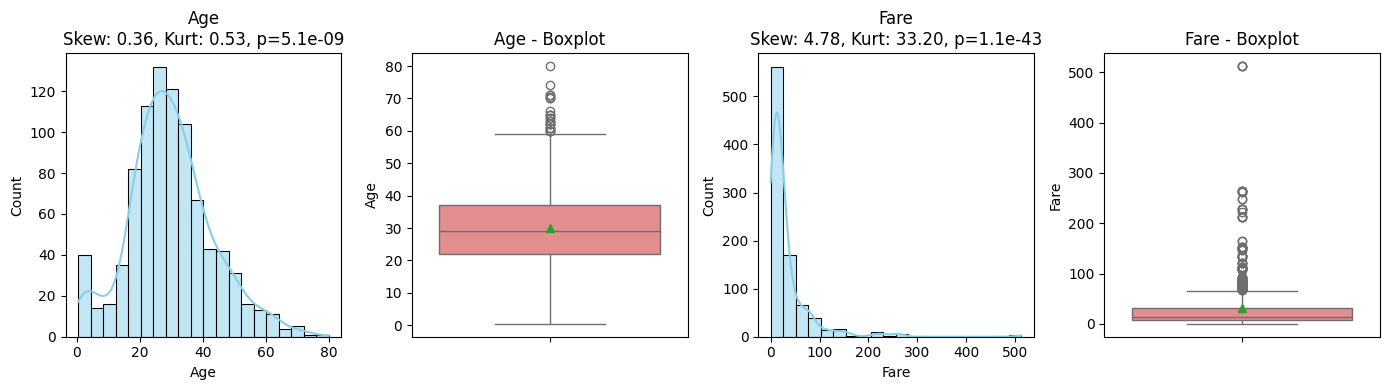

In [191]:
plot_numeric_distributions(data, numeric_cols)

In [192]:
data['log_Fare'] = np.log1p(data['Fare'])

In [193]:
numeric_cols.append('log_Fare')

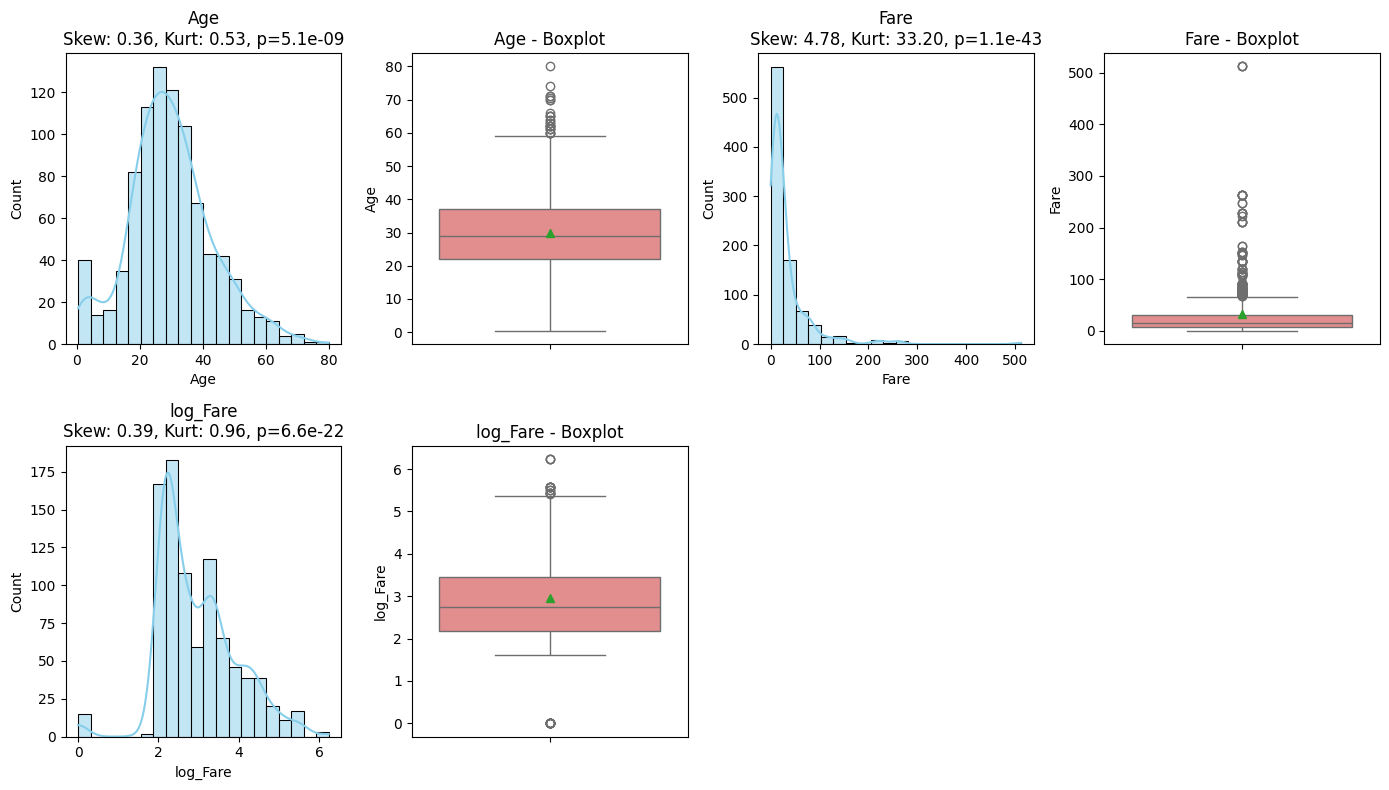

In [194]:
plot_numeric_distributions(data, numeric_cols)

## Cualitativas

In [195]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Titulo          object
Family           int64
IsAlone          int64
log_Fare       float64
dtype: object

In [196]:
categorical_cols = ['Sex', 'Embarked', 'Pclass', 'Titulo', 'IsAlone', 'Family']

In [197]:
data['IsAlone'] = data['IsAlone'].astype('category')

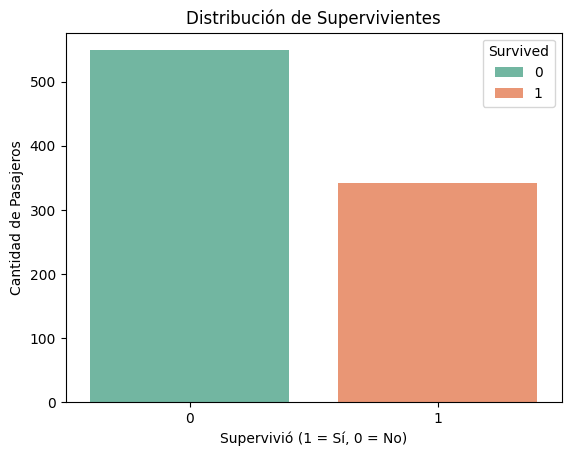

In [198]:
sns.countplot(data=data, x='Survived', hue='Survived', palette='Set2')
plt.title('Distribución de Supervivientes')
plt.xlabel('Supervivió (1 = Sí, 0 = No)')
plt.ylabel('Cantidad de Pasajeros')
plt.show()

In [199]:
def plot_categorical_distributions(data, categorical_cols):
    cols_per_row = 3
    n = len(categorical_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 6, rows * 4))

    for idx, col in enumerate(categorical_cols, 1):
        plt.subplot(rows, cols_per_row, idx)
        sns.countplot(data=data, x=col, hue=col, palette="Set2")
        plt.title(f"{col} Distribution")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

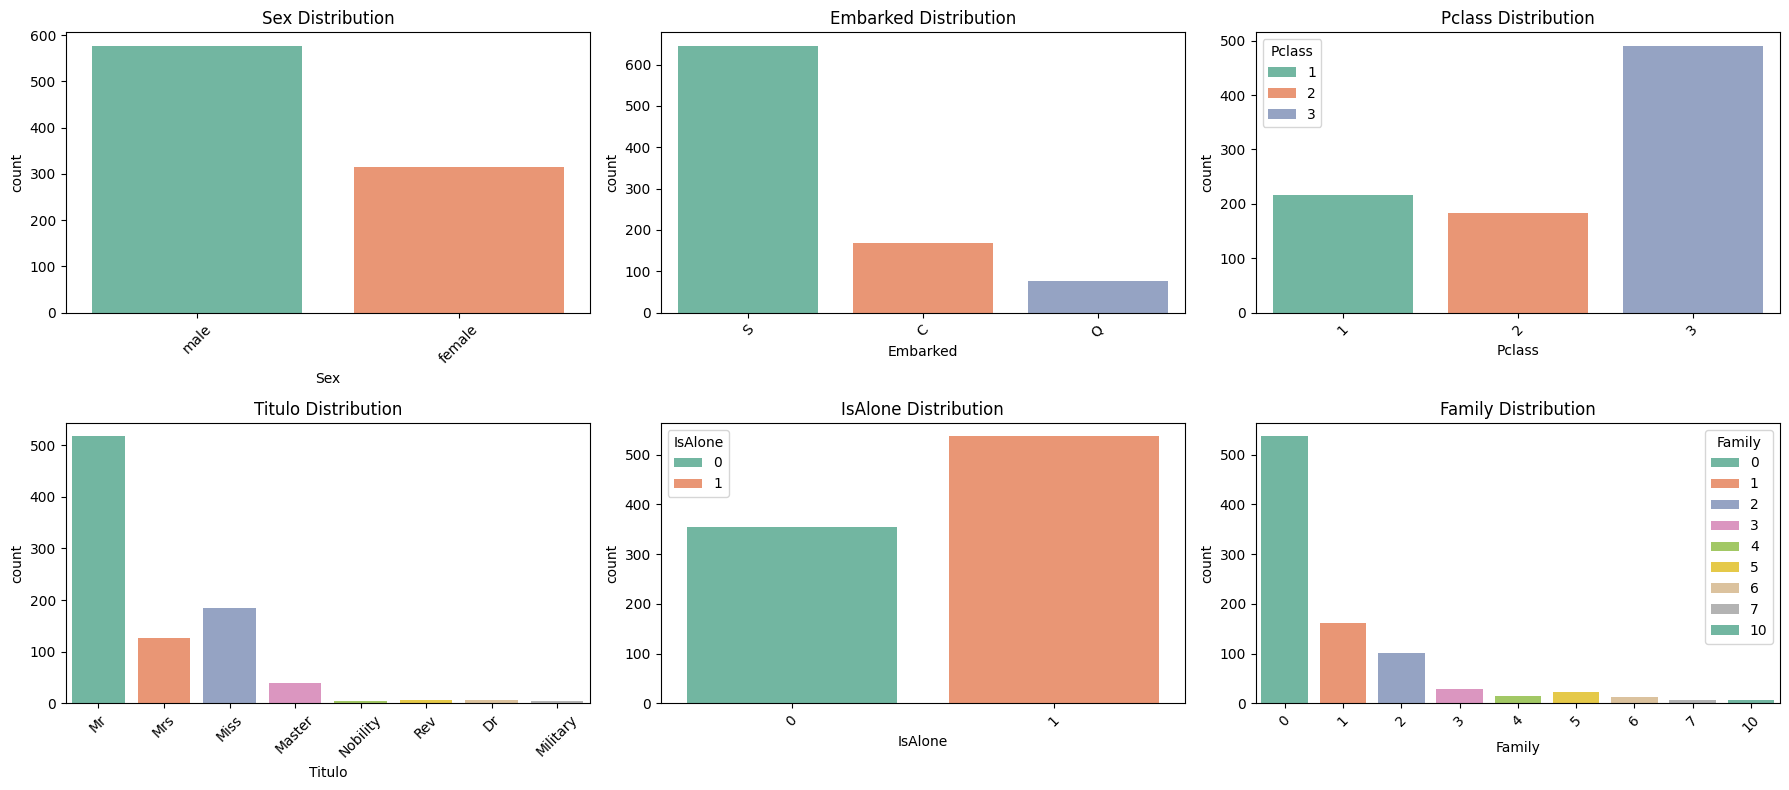

In [200]:
plot_categorical_distributions(data, categorical_cols)

# Mulitivariado

## Cuantitativas con Cuantitativas

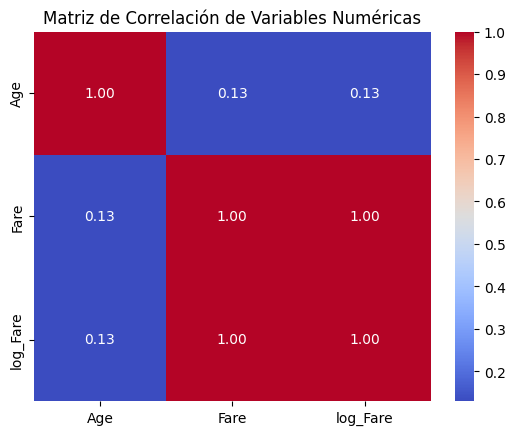

In [201]:
plt.title('Matriz de Correlación de Variables Numéricas')
sns.heatmap(data[numeric_cols].corr('spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

## Cuantitativas con Cualitativas

In [202]:
def plot_numeric_distributions_by_target(data, target, numeric_cols):
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols_per_row*2, idx)
        sns.boxplot(y=data[col], x=data[target], hue=data[target], palette="Set3", showmeans=True)
        plt.title(f"{col} by {target} - Boxplot")

    plt.tight_layout()
    plt.show()

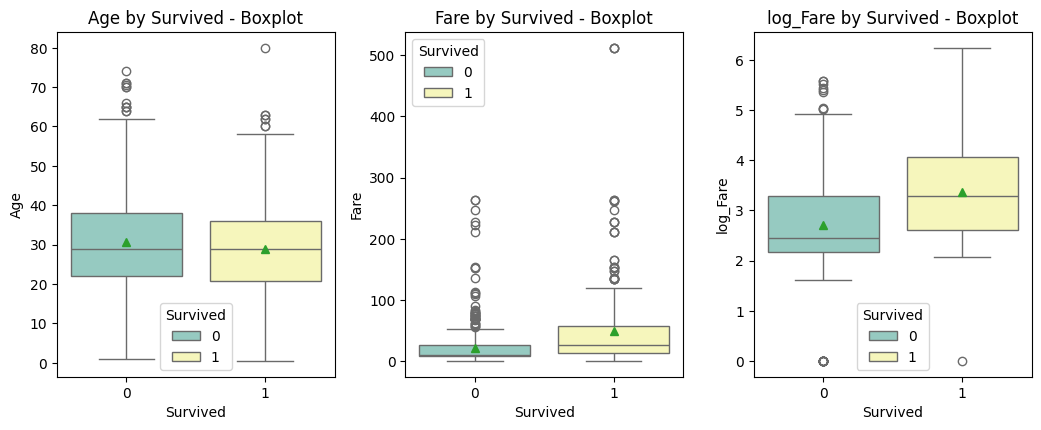

In [203]:
plot_numeric_distributions_by_target(data, 'Survived', numeric_cols)

In [204]:
from scipy.stats import mannwhitneyu
import numpy as np

def mann_whitney_analysis(data, numeric_cols, target_col, alpha=0.05):
    """
    Performs Mann-Whitney U test for numeric variables vs binary target.
    Calculates effect size using r of Rosenthal.

    Parameters:
    -----------
    data : DataFrame
        The dataset containing numeric and target variables
    numeric_cols : list
        List of numeric column names to test
    target_col : str
        Name of the binary target variable
    alpha : float
        Significance level (default 0.05)

    Returns:
    --------
    DataFrame with test results and effect sizes
    """
    results = []

    # Get unique values of target variable
    target_values = data[target_col].unique()
    if len(target_values) != 2:
        raise ValueError(f"Target variable must be binary. Found {len(target_values)} unique values.")

    group1_label, group2_label = target_values[0], target_values[1]

    for variable in numeric_cols:
        # Separate groups by target variable
        group1 = data[data[target_col] == group1_label][variable].dropna()
        group2 = data[data[target_col] == group2_label][variable].dropna()

        # Check if both groups have data
        if len(group1) == 0 or len(group2) == 0:
            print(f"⚠️  Variable {variable}: No hay datos suficientes")
            continue

        # Perform Mann-Whitney U test
        statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

        # Calculate effect size (r of Rosenthal)
        n1, n2 = len(group1), len(group2)
        n_total = n1 + n2

        # Calculate z-score approximation for effect size
        # For large samples, U approaches normal distribution
        mean_u = n1 * n2 / 2
        std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        z_score = abs(statistic - mean_u) / std_u

        # r of Rosenthal = z / sqrt(n)
        r_rosenthal = z_score / np.sqrt(n_total)

        # Interpret effect size
        if r_rosenthal < 0.1:
            effect_size = "Muy pequeño"
        elif r_rosenthal < 0.3:
            effect_size = "Pequeño"
        elif r_rosenthal < 0.5:
            effect_size = "Mediano"
        else:
            effect_size = "Grande"

        # Determine significance
        is_significant = p_value < alpha

        # Calculate descriptive statistics
        median_group1 = group1.median()
        median_group2 = group2.median()
        mean_group1 = group1.mean()
        mean_group2 = group2.mean()

        # Store results
        result = {
            'Variable': variable,
            'U_Statistic': statistic,
            'p_value': p_value,
            'r_Rosenthal': r_rosenthal,
            'Effect_Size': effect_size,
            'Significant': 'Sí' if is_significant else 'No',
            f'Median_{group1_label}': median_group1,
            f'Median_{group2_label}': median_group2,
            f'Mean_{group1_label}': mean_group1,
            f'Mean_{group2_label}': mean_group2,
            f'n_{group1_label}': n1,
            f'n_{group2_label}': n2
        }
        results.append(result)

        # Print detailed results
        print(f"Variable: {variable}")
        print(f"   Mann-Whitney U = {statistic:.2f}")
        print(f"   p-valor = {p_value:.6f}")
        print(f"   r de Rosenthal = {r_rosenthal:.4f} ({effect_size})")
        print(f"   Significativo: {'Sí' if is_significant else 'No'}")
        print(f"   Medianas: {group1_label} = {median_group1:.2f}, {group2_label} = {median_group2:.2f}")
        print(f"   Medias: {group1_label} = {mean_group1:.2f}, {group2_label} = {mean_group2:.2f}")
        print(f"   Tamaños de muestra: {group1_label} = {n1}, {group2_label} = {n2}")

        # Interpretation
        if is_significant:
            if median_group2 > median_group1:
                direction = f"{group2_label} tiende a tener valores MÁS ALTOS"
            else:
                direction = f"{group1_label} tiende a tener valores MÁS ALTOS"
            print(f"Interpretación: {direction}")
        else:
            print(f"Interpretación: No hay diferencia significativa entre grupos")

        print("-" * 60)

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('r_Rosenthal', ascending=False)

    return results_df

In [205]:
# Execute Mann-Whitney analysis for numeric variables vs Churn
numeric_columns = numeric_cols
mann_whitney_results = mann_whitney_analysis(data, numeric_columns, 'Survived')

print("\nRESUMEN DE RESULTADOS:")
print("=" * 60)
display(mann_whitney_results[['Variable', 'U_Statistic', 'p_value', 'r_Rosenthal',
                             'Effect_Size', 'Significant']].round(4))

Variable: Age
   Mann-Whitney U = 97910.50
   p-valor = 0.280502
   r de Rosenthal = 0.0362 (Muy pequeño)
   Significativo: No
   Medianas: 0 = 29.00, 1 = 29.00
   Medias: 0 = 30.55, 1 = 28.85
   Tamaños de muestra: 0 = 549, 1 = 342
Interpretación: No hay diferencia significativa entre grupos
------------------------------------------------------------
Variable: Fare
   Mann-Whitney U = 57806.50
   p-valor = 0.000000
   r de Rosenthal = 0.3235 (Mediano)
   Significativo: Sí
   Medianas: 0 = 10.50, 1 = 26.00
   Medias: 0 = 22.12, 1 = 48.40
   Tamaños de muestra: 0 = 549, 1 = 342
Interpretación: 1 tiende a tener valores MÁS ALTOS
------------------------------------------------------------
Variable: log_Fare
   Mann-Whitney U = 57806.50
   p-valor = 0.000000
   r de Rosenthal = 0.3235 (Mediano)
   Significativo: Sí
   Medianas: 0 = 2.44, 1 = 3.30
   Medias: 0 = 2.71, 1 = 3.37
   Tamaños de muestra: 0 = 549, 1 = 342
Interpretación: 1 tiende a tener valores MÁS ALTOS
----------------------

,Variable,U_Statistic,p_value,r_Rosenthal,Effect_Size,Significant
1,Fare,57806.5,0.0000,0.3235,Mediano,Sí
2,log_Fare,57806.5,0.0000,0.3235,Mediano,Sí
0,Age,97910.5,0.2805,0.0362,Muy pequeño,No


## Cualitativa con Cualitativa

In [206]:
from scipy.stats import chi2_contingency
import numpy as np

def realizar_pruebas_chi2_churn(data, variables_categoricas, target='Survived', alpha=0.05):
    """
    Realiza pruebas chi-cuadrado para variables categóricas vs Churn.
    Calcula V de Cramer como medida del tamaño del efecto.
    """
    resultados = []

    print("ANÁLISIS CHI-CUADRADO: VARIABLES CATEGÓRICAS vs CHURN")
    print("=" * 65)

    for variable in variables_categoricas:
        if variable == target:  # Skip the target variable itself
            continue

        # Crear tabla de contingencia
        tabla_contingencia = pd.crosstab(data[variable], data[target])

        # Realizar prueba chi-cuadrado
        chi2_stat, p_value, dof, expected = chi2_contingency(tabla_contingencia)

        # Calcular V de Cramer (medida del tamaño del efecto)
        n = tabla_contingencia.sum().sum()
        v_cramer = np.sqrt(chi2_stat / (n * (min(tabla_contingencia.shape) - 1)))

        # Interpretar V de Cramer
        if v_cramer < 0.1:
            efecto = "Muy débil"
        elif v_cramer < 0.3:
            efecto = "Débil"
        elif v_cramer < 0.5:
            efecto = "Moderado"
        else:
            efecto = "Fuerte"

        # Determinar si es significativo
        es_significativo = p_value < alpha

        # Guardar resultados
        resultado = {
            'Variable': variable,
            'Chi2_Estadistico': chi2_stat,
            'p_valor': p_value,
            'Grados_Libertad': dof,
            'V_Cramer': v_cramer,
            'Tamaño_Efecto': efecto,
            'Es_Significativo': 'Sí' if es_significativo else 'No',
            'Interpretacion': 'Rechazar H0 (hay asociación)' if es_significativo else 'No rechazar H0 (no hay asociación)'
        }
        resultados.append(resultado)

        # Mostrar resultados detallados para variables significativas con efecto moderado o fuerte
        if es_significativo : # and v_cramer >= 0.2
            print(f"\n Variable: {variable}")
            print(f"   Chi² = {chi2_stat:.4f}")
            print(f"   p-valor = {p_value:.6f}")
            print(f"   V de Cramer = {v_cramer:.4f} ({efecto})")
            print(f"   Resultado: {resultado['Interpretacion']}")
            print(f"   Tabla de Contingencia:")
            # Mostrar tabla con porcentajes
            tabla_pct = pd.crosstab(data[variable], data[target], normalize='index') * 100
            print(tabla_pct.round(1))
            print("-" * 50)

    # Crear DataFrame con todos los resultados
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('V_Cramer', ascending=False)

    return df_resultados

# Realizar las pruebas chi-cuadrado
resultados_chi2 = realizar_pruebas_chi2_churn(data, categorical_cols)

print("\n RESUMEN DE TODAS LAS VARIABLES:")
print("=" * 65)
display(resultados_chi2[['Variable', 'Chi2_Estadistico', 'p_valor', 'V_Cramer',
                        'Tamaño_Efecto', 'Es_Significativo']].round(4))

ANÁLISIS CHI-CUADRADO: VARIABLES CATEGÓRICAS vs CHURN

 Variable: Sex
   Chi² = 260.7170
   p-valor = 0.000000
   V de Cramer = 0.5409 (Fuerte)
   Resultado: Rechazar H0 (hay asociación)
   Tabla de Contingencia:
Survived     0     1
Sex                 
female    25.8  74.2
male      81.1  18.9
--------------------------------------------------

 Variable: Embarked
   Chi² = 25.9645
   p-valor = 0.000002
   V de Cramer = 0.1707 (Débil)
   Resultado: Rechazar H0 (hay asociación)
   Tabla de Contingencia:
Survived     0     1
Embarked            
C         44.6  55.4
Q         61.0  39.0
S         66.1  33.9
--------------------------------------------------

 Variable: Pclass
   Chi² = 102.8890
   p-valor = 0.000000
   V de Cramer = 0.3398 (Moderado)
   Resultado: Rechazar H0 (hay asociación)
   Tabla de Contingencia:
Survived     0     1
Pclass              
1         37.0  63.0
2         52.7  47.3
3         75.8  24.2
--------------------------------------------------

 Variable: Ti

,Variable,Chi2_Estadistico,p_valor,V_Cramer,Tamaño_Efecto,Es_Significativo
3,Titulo,292.7824,0.0,0.5732,Fuerte,Sí
0,Sex,260.7170,0.0,0.5409,Fuerte,Sí
2,Pclass,102.8890,0.0,0.3398,Moderado,Sí
5,Family,80.6723,0.0,0.3009,Moderado,Sí
4,IsAlone,36.0005,0.0,0.2010,Débil,Sí
1,Embarked,25.9645,0.0,0.1707,Débil,Sí


In [207]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve)

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     891 non-null    object  
 12  Titulo       891 non-null    object  
 13  Family       891 non-null    int64   
 14  IsAlone      891 non-null    category
 15  log_Fare     891 non-null    float64 
dtypes: category(1), float64(3), int64(6), object(6)
memory usage: 105.5+ KB


In [209]:
# data['Pclass'] = data['Pclass'].astype('category')

In [210]:
df = data.copy()
x_features = ['Pclass', 'Sex', 'Family', 'IsAlone', 'Titulo', 'log_Fare', 'Age']
X = df[x_features]
X = pd.get_dummies(X, drop_first=True)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))



Accuracy: 0.8324022346368715
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       110
           1       0.77      0.81      0.79        69

    accuracy                           0.83       179
   macro avg       0.82      0.83      0.82       179
weighted avg       0.83      0.83      0.83       179

[[93 17]
 [13 56]]
ROC AUC: 0.8736495388669303


In [211]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features="sqrt", random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Random Forest Classifier
Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.75      0.75      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

[[93 17]
 [17 52]]
ROC AUC: 0.8401185770750988


# K MEANS

In [212]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Example columns – adjust to your dataframe:
num_cols = ['Age','Fare']
cat_cols = ['Pclass','Sex', 'Embarked', 'Titulo', 'IsAlone', 'Family']

# Basic cleaning (example): impute simple values
df = data.copy()
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), cat_cols)
])

X = pre.fit_transform(df)

results = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X)
    # silhouette works with Euclidean; CH/DB prefer dense arrays
    X_dense = X.toarray() if hasattr(X, "toarray") else X
    sil = silhouette_score(X, labels, metric='euclidean')
    ch  = calinski_harabasz_score(X_dense, labels)
    db  = davies_bouldin_score(X_dense, labels)
    results.append((k, sil, ch, db, km.inertia_))

for k, sil, ch, db, inertia in results:
    print(f"k={k}: silhouette={sil:.3f} | CH={ch:.1f} | DB={db:.3f} | inertia={inertia:.1f}")


k=2: silhouette=0.233 | CH=191.3 | DB=2.009 | inertia=3432.1
k=3: silhouette=0.228 | CH=202.3 | DB=1.730 | inertia=2865.1
k=4: silhouette=0.228 | CH=194.1 | DB=1.564 | inertia=2517.8
k=5: silhouette=0.222 | CH=179.5 | DB=1.598 | inertia=2303.6
k=6: silhouette=0.238 | CH=165.3 | DB=1.630 | inertia=2156.8
k=7: silhouette=0.241 | CH=163.1 | DB=1.537 | inertia=1979.6
k=8: silhouette=0.270 | CH=167.9 | DB=1.470 | inertia=1789.4
k=9: silhouette=0.252 | CH=149.9 | DB=1.469 | inertia=1767.5
k=10: silhouette=0.188 | CH=143.4 | DB=1.622 | inertia=1692.0
